## CSC 578 HW\#7 Intel Image Classification Competition (Fall 2023)

### Name:

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [15]:
# mount google drive on colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#Unzip data folder

import zipfile
import os

# Path to the zip file in Google Drive
zip_path = '/content/drive/My Drive/csc-578-hw7-fall-2023.zip'

# Unzipping the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content')
    print("Unzipped the dataset.")

Unzipped the dataset.


In [7]:
# List the contents of /content directory
!ls /content

csc-578-hw7-fall-2023  drive  sample_data


In [8]:
# Data Preprocessing

# Path to the dataset
train_dir = '/content/csc-578-hw7-fall-2023/train'
test_dir = '/content/csc-578-hw7-fall-2023/test_pred'




# Define image properties
img_width, img_height = 150, 150
input_shape = (img_width, img_height, 3)

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # set validation split
)

# Load and preprocess the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load and preprocess the validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

# Data generator for test set
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 11190 images belonging to 6 classes.
Found 2796 images belonging to 6 classes.
Found 2993 images belonging to 1 classes.


In [9]:
# Define a CNN Model

def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(6, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

Epoch 1/10
349/349 [==============================] - 803s 2s/step - loss: 1.1967 - accuracy: 0.5210 - val_loss: 1.0463 - val_accuracy: 0.5988
Epoch 2/10
349/349 [==============================] - 812s 2s/step - loss: 0.9797 - accuracy: 0.6192 - val_loss: 0.9028 - val_accuracy: 0.6527
Epoch 3/10
349/349 [==============================] - 810s 2s/step - loss: 0.9127 - accuracy: 0.6534 - val_loss: 0.8905 - val_accuracy: 0.6735
Epoch 4/10
349/349 [==============================] - 782s 2s/step - loss: 0.8399 - accuracy: 0.6883 - val_loss: 0.7650 - val_accuracy: 0.7180
Epoch 5/10
349/349 [==============================] - 781s 2s/step - loss: 0.7914 - accuracy: 0.7064 - val_loss: 0.8094 - val_accuracy: 0.7015
Epoch 6/10
349/349 [==============================] - 803s 2s/step - loss: 0.7687 - accuracy: 0.7196 - val_loss: 0.6876 - val_accuracy: 0.7640
Epoch 7/10
349/349 [==============================] - 775s 2s/step - loss: 0.7276 - accuracy: 0.7361 - val_loss: 0.6701 - val_accuracy: 0.7644

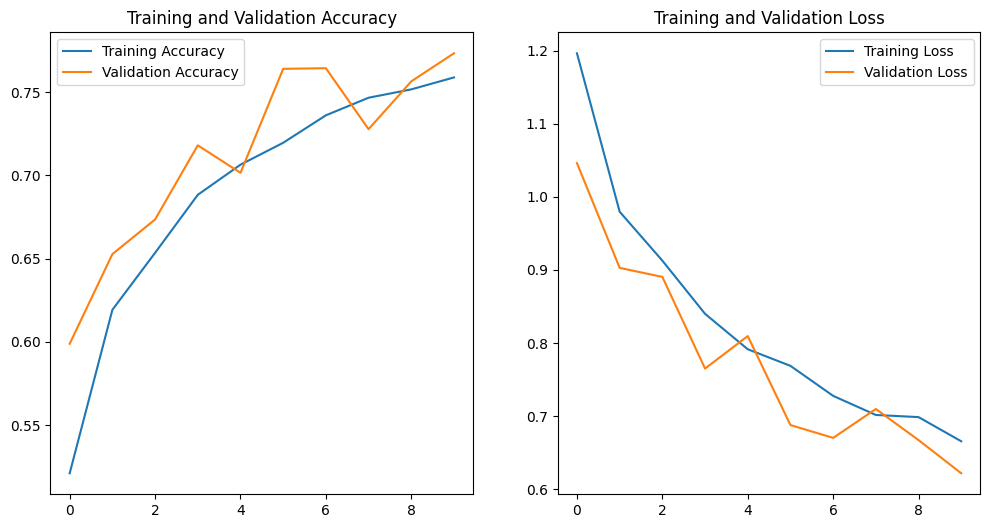

In [7]:
# Train and Evaluate the Model

epochs = 10
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Plotting training & validation accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [9]:
# Generate Predictions for Test Data

# Predicting probabilities
test_generator.reset()
print("Number of test samples:", test_generator.samples)

predictions = model.predict(test_generator, steps=test_generator.samples)

# Generating a DataFrame with predictions
predictions_df = pd.DataFrame(predictions, columns=train_generator.class_indices.keys())
predictions_df['fnum'] = test_generator.filenames
predictions_df['fnum'] = predictions_df['fnum'].apply(lambda x: int(x.split('/')[1].split('.')[0]))

predictions_df = predictions_df[['fnum'] + list(train_generator.class_indices.keys())]
predictions_df.sort_values('fnum', inplace=True)

# Saving predictions to CSV for submission
predictions_df.to_csv('submission.csv', index=False)

Number of test samples: 2993
2993/2993 [==============================] - 80s 26ms/step


**Second Submission**

In [13]:
def create_enhanced_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Flatten(),

        Dense(512, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),

        Dense(256, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),

        Dense(6, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create the enhanced model
enhanced_model = create_enhanced_model()
enhanced_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 74, 74, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_8 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                      

Epoch 1/15
349/349 [==============================] - 105s 284ms/step - loss: 1.5128 - accuracy: 0.4568 - val_loss: 2.4895 - val_accuracy: 0.2389
Epoch 2/15
349/349 [==============================] - 97s 277ms/step - loss: 1.2280 - accuracy: 0.5511 - val_loss: 1.0143 - val_accuracy: 0.5966
Epoch 3/15
349/349 [==============================] - 100s 287ms/step - loss: 1.1253 - accuracy: 0.5819 - val_loss: 0.8817 - val_accuracy: 0.6663
Epoch 4/15
349/349 [==============================] - 97s 277ms/step - loss: 1.0467 - accuracy: 0.6166 - val_loss: 0.8144 - val_accuracy: 0.7040
Epoch 5/15
349/349 [==============================] - 98s 280ms/step - loss: 0.9786 - accuracy: 0.6363 - val_loss: 0.7770 - val_accuracy: 0.7213
Epoch 6/15
349/349 [==============================] - 120s 345ms/step - loss: 0.9370 - accuracy: 0.6567 - val_loss: 0.7791 - val_accuracy: 0.7112
Epoch 7/15
349/349 [==============================] - 100s 286ms/step - loss: 0.9010 - accuracy: 0.6744 - val_loss: 0.7400 - va

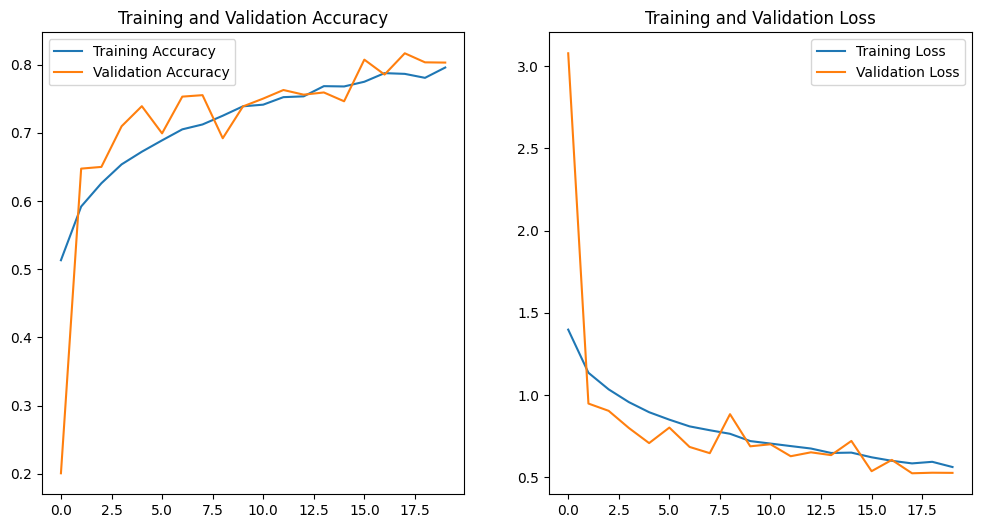

In [14]:
# Train and Evaluate the Model

enhanced_epochs = 15

enhanced_history = enhanced_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=enhanced_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)
# Plotting training & validation accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Generate Predictions for Test Data

# Predicting probabilities
test_generator.reset()
print("Number of test samples:", test_generator.samples)
enhanced_predictions = enhanced_model.predict(test_generator, steps=test_generator.samples)

# Generating a DataFrame with predictions
enhanced_predictions_df = pd.DataFrame(enhanced_predictions, columns=train_generator.class_indices.keys())

# Extracting file numbers from filenames
enhanced_predictions_df['fnum'] = [int(fname.split('/')[1].split('.')[0]) for fname in test_generator.filenames]

# Sort the DataFrame based on file numbers (fnum)
enhanced_predictions_df.sort_values('fnum', inplace=True)

# Saving predictions to CSV for submission
enhanced_predictions_df.to_csv('submission2.csv', index=False)

**Third Submission**

In [10]:
# Define an Even More Enhanced CNN Model

def create_enhanced_model2():
    model = Sequential([
        Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Flatten(),

        Dense(1024, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),

        Dense(512, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),

        Dense(6, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create model
enhanced_model2 = create_enhanced_model2()
enhanced_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 74, 74, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 128)       0         
 g2D)                                                            
                                                      

Epoch 1/20
349/349 [==============================] - 149s 379ms/step - loss: 1.3979 - accuracy: 0.5133 - val_loss: 3.0773 - val_accuracy: 0.2008
Epoch 2/20
349/349 [==============================] - 135s 387ms/step - loss: 1.1358 - accuracy: 0.5920 - val_loss: 0.9487 - val_accuracy: 0.6476
Epoch 3/20
349/349 [==============================] - 111s 317ms/step - loss: 1.0349 - accuracy: 0.6262 - val_loss: 0.9044 - val_accuracy: 0.6501
Epoch 4/20
349/349 [==============================] - 116s 331ms/step - loss: 0.9573 - accuracy: 0.6539 - val_loss: 0.8001 - val_accuracy: 0.7098
Epoch 5/20
349/349 [==============================] - 108s 310ms/step - loss: 0.8961 - accuracy: 0.6724 - val_loss: 0.7084 - val_accuracy: 0.7392
Epoch 6/20
349/349 [==============================] - 131s 376ms/step - loss: 0.8508 - accuracy: 0.6891 - val_loss: 0.8027 - val_accuracy: 0.6994
Epoch 7/20
349/349 [==============================] - 114s 327ms/step - loss: 0.8100 - accuracy: 0.7052 - val_loss: 0.6851 -

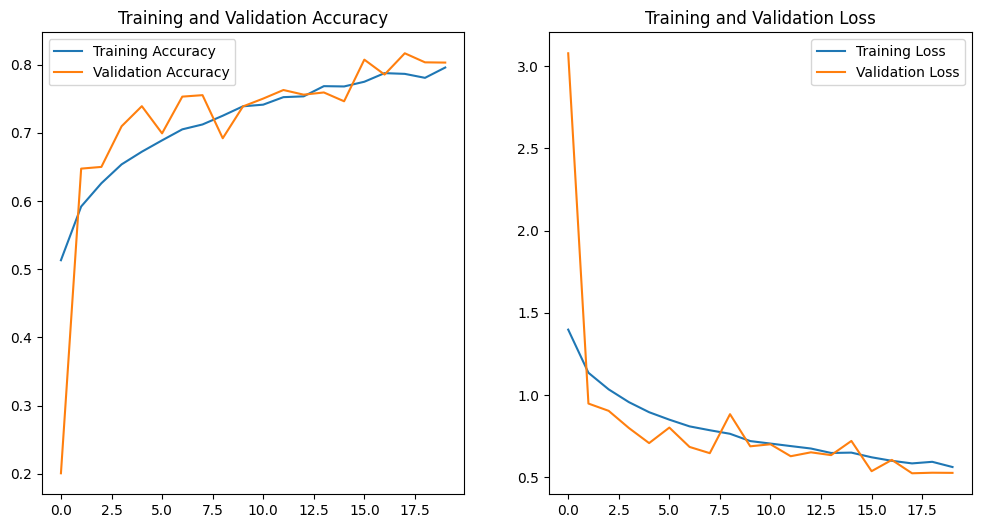

In [11]:
# Train and Evaluate the Model

epochs = 20  # Increased epochs
history = enhanced_model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

# Plotting training & validation accuracy and loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [12]:
# Generate Predictions for Test Data

test_generator.reset()
print("Number of test samples:", test_generator.samples)

# Use  model for predictions
predictions = enhanced_model2.predict(test_generator, steps=test_generator.samples)

# Generating a DataFrame with predictions
predictions_df = pd.DataFrame(predictions, columns=train_generator.class_indices.keys())
predictions_df['fnum'] = test_generator.filenames
predictions_df['fnum'] = predictions_df['fnum'].apply(lambda x: int(x.split('/')[1].split('.')[0]))

predictions_df = predictions_df[['fnum'] + list(train_generator.class_indices.keys())]
predictions_df.sort_values('fnum', inplace=True)

# Saving predictions to CSV for submission
predictions_df.to_csv('submission3.csv', index=False)

Number of test samples: 2993
2993/2993 [==============================] - 10s 3ms/step




This notebook presents a basic workflow for building and evaluating a CNN model for the Intel Image Classification competition. It includes data preprocessing, model definition, training, evaluation, and preparing a Kaggle submission.

